# Laboratory work #3

Import all significant libraries for this project.

In [1]:
# Import TensorFlow & Keras Libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import image_dataset_from_directory
from keras.layers import TextVectorization, Embedding, LSTM, SpatialDropout1D
from keras.utils import to_categorical

# Import scikit-learn libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import libraries for text cleaning
import re
import string
import nltk
from nltk.corpus import stopwords

# Import other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

In [6]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

## Exercise 1

#### Downloading Dataset
Our dataset is Possible Asteroid Impacts with Earth (from [kaggle](https://www.kaggle.com/datasets/nasa/asteroid-impacts))

### Preprocessing Dataset

In [2]:
# Loading dataset to pandas DataFrame
asteroid_df = pd.read_csv("datasets\\asteroid_dataset\\asteroid_classification.csv")

In [3]:
# Drop unnecessary columns for analysis from the dataframe
asteroid_df.drop(["Object Name", "Epoch (TDB)", "Perihelion Argument (deg)", "Node Longitude (deg)",
                  "Mean Anomoly (deg)", "Perihelion Distance (AU)", "Aphelion Distance (AU)",
                  "Minimum Orbit Intersection Distance (AU)", "Orbital Reference"], axis=1, inplace=True)
print(asteroid_df.columns)

Index(['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity',
       'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude'],
      dtype='object')


In [4]:
# Drop null values of dataframe as we have only one null value
asteroid_df.dropna(inplace=True)
asteroid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15634 entries, 0 to 15634
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Object Classification    15634 non-null  object 
 1   Orbit Axis (AU)          15634 non-null  float64
 2   Orbit Eccentricity       15634 non-null  float64
 3   Orbit Inclination (deg)  15634 non-null  float64
 4   Orbital Period (yr)      15634 non-null  float64
 5   Asteroid Magnitude       15634 non-null  float64
dtypes: float64(5), object(1)
memory usage: 855.0+ KB


In [5]:
# Change class names
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Apollo Asteroid" ,
                                          "Apollo", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Aten Asteroid",
                                          "Aten", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Amor Asteroid",
                                          "Amor", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Apohele Asteroid",
                                          "Apohele", inplace=True)
# Drop unnecessary class
necessary_class = ["Apollo", "Aten", "Amor"]
asteroid_df = asteroid_df[asteroid_df["Object Classification"].isin(necessary_class)]

In [6]:
def remove_outliers(dataframe, features):
    """Function to remove the outliers;
    :param dataframe: pandas DataFrame with data;
    :param features: list with features from dataframe.
    """
    # Copy dataframe to another variable
    dataframe_copy = dataframe.copy()

    # Iterate through features
    for feature in features:
        if dataframe[feature].dtype == object:
            continue
        # Calculate q1, q3 and iqr
        q3 = dataframe[feature].quantile(0.75)
        q1 = dataframe[feature].quantile(0.25)
        iqr = q3 - q1

        # Get local minimum and maximum
        local_min = q1 - (1.5 * iqr)
        local_max = q3 + (1.5 * iqr)

        # Remove the outliers
        dataframe_copy = dataframe_copy[(dataframe_copy[feature] >= local_min) &
                                        (dataframe_copy[feature] <= local_max)]

    return dataframe_copy

In [7]:
# Extract features from the df
asteroid_features = asteroid_df.columns.tolist()
print(asteroid_features)

['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity', 'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude']


In [8]:
# Remove outliers from the dataframe
asteroid_df = remove_outliers(asteroid_df, asteroid_features)

In [9]:
# View count of class names
print(asteroid_df.iloc[:, 0].value_counts())

Apollo    6651
Amor      5686
Aten       965
Name: Object Classification, dtype: int64


In [10]:
# Define number of classes
num_classes = len(necessary_class)

In [11]:
# Normalise dataset
norm_asteroid_df = asteroid_df.copy()
# apply normalization techniques
for column in norm_asteroid_df:
    if norm_asteroid_df[column].dtype == object:
        continue
    norm_asteroid_df[column] = norm_asteroid_df[column] / norm_asteroid_df[column].abs().max()
# View normalised dataset
print(norm_asteroid_df.head())

  Object Classification  Orbit Axis (AU)  Orbit Eccentricity  \
1                  Amor         0.807646            0.590282   
2                  Amor         0.758732            0.610967   
4                  Amor         0.587438            0.469295   
8                  Amor         0.570204            0.427279   
9                Apollo         0.418531            0.469619   

   Orbit Inclination (deg)  Orbital Period (yr)  Asteroid Magnitude  
1                 0.296677             0.727119            0.492063  
2                 0.239656             0.661017            0.425397  
4                 0.304293             0.450847            0.561905  
8                 0.216477             0.430508            0.419048  
9                 0.240286             0.271186            0.451746  


In [12]:
# Edit name of column "Object Classification" with "_"
# For using this name in next cell
number_asteroid_df = norm_asteroid_df.copy()
number_asteroid_df.rename(columns={"Object Classification": "Object_Classification"}, inplace=True)
# Replace string class to numbers
obj_class = {"Apollo": 0, "Aten": 1, "Amor": 2}
number_asteroid_df.Object_Classification = [obj_class[item] for item in number_asteroid_df.Object_Classification]
# View new dataset
print(number_asteroid_df.head())

   Object_Classification  Orbit Axis (AU)  Orbit Eccentricity  \
1                      2         0.807646            0.590282   
2                      2         0.758732            0.610967   
4                      2         0.587438            0.469295   
8                      2         0.570204            0.427279   
9                      0         0.418531            0.469619   

   Orbit Inclination (deg)  Orbital Period (yr)  Asteroid Magnitude  
1                 0.296677             0.727119            0.492063  
2                 0.239656             0.661017            0.425397  
4                 0.304293             0.450847            0.561905  
8                 0.216477             0.430508            0.419048  
9                 0.240286             0.271186            0.451746  


In [13]:
# One-hot Encoding the Object Classification Feature
one_hot = OneHotEncoder()
# Copy our dataset
onehot_asteroid_df = norm_asteroid_df.copy()
# Fitting one-hot encoder
encoded = one_hot.fit_transform(onehot_asteroid_df[["Object Classification"]])
onehot_asteroid_df[one_hot.categories_[0]] = encoded.toarray()
# Drop unnecessary "Object Classification" feature
onehot_asteroid_df.drop(["Object Classification"], axis=1, inplace=True)
print(onehot_asteroid_df.head())

   Orbit Axis (AU)  Orbit Eccentricity  Orbit Inclination (deg)  \
1         0.807646            0.590282                 0.296677   
2         0.758732            0.610967                 0.239656   
4         0.587438            0.469295                 0.304293   
8         0.570204            0.427279                 0.216477   
9         0.418531            0.469619                 0.240286   

   Orbital Period (yr)  Asteroid Magnitude  Amor  Apollo  Aten  
1             0.727119            0.492063   1.0     0.0   0.0  
2             0.661017            0.425397   1.0     0.0   0.0  
4             0.450847            0.561905   1.0     0.0   0.0  
8             0.430508            0.419048   1.0     0.0   0.0  
9             0.271186            0.451746   0.0     1.0   0.0  


In [14]:
# Change data type in one-hot encoded column
column_dtype_dict = {"Amor": int,
                     "Apollo": int,
                     "Aten": int}
norm_onehot_asteroid_df = onehot_asteroid_df.astype(column_dtype_dict)
print(norm_onehot_asteroid_df.dtypes)
print(norm_onehot_asteroid_df.head())

Orbit Axis (AU)            float64
Orbit Eccentricity         float64
Orbit Inclination (deg)    float64
Orbital Period (yr)        float64
Asteroid Magnitude         float64
Amor                         int32
Apollo                       int32
Aten                         int32
dtype: object
   Orbit Axis (AU)  Orbit Eccentricity  Orbit Inclination (deg)  \
1         0.807646            0.590282                 0.296677   
2         0.758732            0.610967                 0.239656   
4         0.587438            0.469295                 0.304293   
8         0.570204            0.427279                 0.216477   
9         0.418531            0.469619                 0.240286   

   Orbital Period (yr)  Asteroid Magnitude  Amor  Apollo  Aten  
1             0.727119            0.492063     1       0     0  
2             0.661017            0.425397     1       0     0  
4             0.450847            0.561905     1       0     0  
8             0.430508            0.419048 

### Split Dataset to Train & Test sets

In [14]:
# Split Categorical Dataset
x = norm_asteroid_df.drop(["Object Classification"], axis=1)
y = norm_asteroid_df["Object Classification"]
# Split to train test sets
catg_X_train, catg_X_test, catg_y_train, catg_y_test = train_test_split(x, y, test_size=0.2)

In [15]:
# Split Numeric Dataset
x = number_asteroid_df.drop(["Object_Classification"], axis=1)
y = number_asteroid_df["Object_Classification"]
# Split to train test sets
num_X_train, num_X_test, num_y_train, num_y_test = train_test_split(x, y, test_size=0.2)

In [15]:
# Split to train, validation and test sets
oneh_train, oneh_valid, oneh_test = np.split(norm_onehot_asteroid_df.sample(frac=1), [int(0.8*len(norm_onehot_asteroid_df)), int(0.9*len(norm_onehot_asteroid_df))])

In [71]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    """
    Function for converting dataframe var to tf dataset;
    :param dataframe: pandas DataFrame object;
    :param shuffle: bool for defining shuffle this dataset or not;
    :param batch_size: size of batch for batching dataset;
    :return: formed dataset for use in training.
    """
    # Copy dataframe to new vars
    df = dataframe.copy()
    # Drop unnecessary columns for the data part and forme new label part
    df = df.drop(["Apollo", "Aten", "Amor"], axis=1)
    labels = dataframe[["Apollo", "Aten", "Amor"]]
    # Convert dataframe with data to tensor with concrete dtype -- float32
    df = tf.constant(df, dtype=tf.float32)
    # Make TensorFlow Dataset
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    # Optimize TF Dataset for loading to model
    # Shuffle for training dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    # Batching dataset
    ds = ds.batch(batch_size)
    # Prefetching dataset for better performance on GPU
    ds = ds.prefetch(batch_size)
    return ds

In [72]:
# Define batch size
batch_size = 32
# Get TensorFlow Dataset object
train_ds = df_to_dataset(oneh_train, batch_size=batch_size)
valid_ds = df_to_dataset(oneh_valid, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(oneh_test, shuffle=False, batch_size=batch_size)

In [73]:
# View new train dataset
for onehot in train_ds.take(1):
    print(onehot)

(<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[0.691573  , 0.74822235, 0.05346096, 0.5762712 , 0.86031747],
       [0.74713033, 0.60881275, 0.23767088, 0.64576274, 0.6952381 ],
       [0.61165017, 0.52908856, 0.23881587, 0.4779661 , 0.7777778 ],
       [0.3599437 , 0.35811248, 0.3107529 , 0.21694915, 0.6920635 ],
       [0.51602435, 0.45593622, 0.32116282, 0.37118644, 0.74920636],
       [0.49398512, 0.4771601 , 0.10288757, 0.34745762, 0.85714287],
       [0.34473047, 0.37319544, 0.02777941, 0.20338982, 0.768254  ],
       [0.35721937, 0.37621203, 0.14390735, 0.21355931, 0.73968256],
       [0.33420062, 0.5287654 , 0.13169159, 0.19322033, 0.71746033],
       [0.5683063 , 0.38149107, 0.15756781, 0.42881355, 0.6507937 ],
       [0.41482753, 0.6149537 , 0.16654329, 0.2677966 , 0.7714286 ],
       [0.4875264 , 0.65513897, 0.69243616, 0.34067798, 0.7015873 ],
       [0.51841193, 0.6356389 , 0.69989526, 0.37288135, 0.584127  ],
       [0.33769017, 0.17420815, 0.6442519 , 0.1966101

### Build model

In [2]:
def model_compile(model, loss_func, learn_rate=0.001):
    """
    Help function for compiling model;
    :param model: built model;
    :param loss_func: loss function for compiling;
    :param learn_rate: learning rate for optimizer.
    """
    model.compile(loss=loss_func,
                  optimizer=Adam(learning_rate=learn_rate),
                  metrics=["accuracy"])

In [75]:
# Set Input layer for input data
input_shape = len(asteroid_features)-1
inputs = Input(shape=(input_shape,), name="model_inputs")

In [76]:
# Set Dense (Fully Connected) layer with 100 hidden unit and "relu" activation function
x = Dense(100, activation="relu")(inputs)
# Set another Dense layer with 10 hidden unit and "relu" activation function
x = Dense(10, activation="relu")(x)
# Set output layer with num_classes hidden unit and "sigmoid" activation function
outputs = Dense(num_classes, activation="sigmoid")(x)

In [77]:
# Define our model
onehot_model = Model(inputs, outputs, name="onehot_model")

In [78]:
# View summary of the model
onehot_model.summary()

Model: "onehot_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_inputs (InputLayer)   [(None, 5)]               0         
                                                                 
 dense_19 (Dense)            (None, 100)               600       
                                                                 
 dense_20 (Dense)            (None, 10)                1010      
                                                                 
 dense_21 (Dense)            (None, 3)                 33        
                                                                 
Total params: 1,643
Trainable params: 1,643
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Compile the model
model_compile(onehot_model, CategoricalCrossentropy())

### Fit model

In [80]:
# Fitting the model
onehot_history = onehot_model.fit(train_ds,
                                  batch_size=batch_size,
                                  epochs=10,
                                  validation_data=valid_ds,
                                  use_multiprocessing=True)

Epoch 1/10
333/333 [==============================] - 3s 4ms/step - loss: 0.7306 - accuracy: 0.6950 - val_loss: 0.5407 - val_accuracy: 0.7917
Epoch 2/10
333/333 [==============================] - 1s 4ms/step - loss: 0.4504 - accuracy: 0.8159 - val_loss: 0.3928 - val_accuracy: 0.8098
Epoch 3/10
333/333 [==============================] - 1s 4ms/step - loss: 0.3297 - accuracy: 0.8551 - val_loss: 0.2794 - val_accuracy: 0.9038
Epoch 4/10
333/333 [==============================] - 1s 4ms/step - loss: 0.2540 - accuracy: 0.9100 - val_loss: 0.2196 - val_accuracy: 0.9308
Epoch 5/10
333/333 [==============================] - 1s 4ms/step - loss: 0.2061 - accuracy: 0.9354 - val_loss: 0.1861 - val_accuracy: 0.9338
Epoch 6/10
333/333 [==============================] - 1s 4ms/step - loss: 0.1825 - accuracy: 0.9387 - val_loss: 0.1567 - val_accuracy: 0.9549
Epoch 7/10
333/333 [==============================] - 1s 4ms/step - loss: 0.1591 - accuracy: 0.9492 - val_loss: 0.1404 - val_accuracy: 0.9624
Epoch 

### Evaluate model

In [82]:
loss, accuracy = onehot_model.evaluate(test_ds)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set = {accuracy}")

42/42 [==============================] - 0s 3ms/step - loss: 0.1219 - accuracy: 0.9609
Model loss on the test set: 0.12188560515642166
Model accuracy on the test set = 0.960931658744812


Last best result on this data is that:
**model** - GridSearch(SVM)
**result** - accuracy = 0.99

Now result is
**model** - Fully connected feed-forward network
**result** - accuracy = 0.96

In summary, we can say model (GridSearch(SVM)) have best fit on this data!

## Exercise 2

#### Downloading Dataset
Our dataset is Food Classification Dataset (from [kaggle](https://www.kaggle.com/datasets/kmader/food41))

### Preprocessing Dataset

In [22]:
def prepare_ds(dataset, shuffle=False, batch=32):
    """
    Help function for prepare dataset for better performance;
    :param dataset: TensorFlow Dataset object;
    :param shuffle: bool for define make shuffle or not;
    :param batch: size of batch in dataset;
    :return: normalized and prepared dataset.
    """
    # Shuffling dataset
    if shuffle:
        dataset.shuffle(buffer_size=len(dataset))
    # Batching dataset
    dataset.batch(batch)
    # Augmenting dataset
    norm_layer = Rescaling(1./255)
    ds = dataset.map(lambda x, y: (norm_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    image_batch, labels_batch = next(iter(ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)


def plot_loss_curves(history):
    """
    Function for plot the validation and training data separately
    :param history: history of loss curves from fitted model.
    :return: separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


In [4]:
# Define train and test dir
train_dir = pathlib.Path("datasets\\5_food_classes_all_data\\train\\")
test_dir = pathlib.Path("datasets\\5_food_classes_all_data\\test\\")

In [5]:
train_dir

WindowsPath('datasets/5_food_classes_all_data/train')

In [6]:
# Define some hyperparameters
batch_size = 28
image_size = (256, 256)
random_seed = 17
# Set train and test datasets
train_ds = image_dataset_from_directory(train_dir,
                                        label_mode="categorical",
                                        validation_split=0.2,
                                        subset="training",
                                        seed=random_seed,
                                        image_size=image_size)
val_ds = image_dataset_from_directory(train_dir,
                                      label_mode="categorical",
                                      validation_split=0.2,
                                      subset="validation",
                                      seed=random_seed,
                                      image_size=image_size)
test_ds = image_dataset_from_directory(test_dir,
                                       label_mode="categorical",
                                       # validation_split=0.5,
                                       # subset="training",
                                       seed=random_seed,
                                       image_size=image_size)

Found 3750 files belonging to 5 classes.
Using 3000 files for training.
Found 3750 files belonging to 5 classes.
Using 750 files for validation.
Found 1250 files belonging to 5 classes.


In [7]:
# View on train Dataset
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [8]:
# View on train Dataset
next(iter(train_ds))

(<tf.Tensor: shape=(28, 256, 256, 3), dtype=float32, numpy=
 array([[[[2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          [2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          [2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          ...,
          [2.4725000e+02, 1.4975000e+02, 4.5000000e+00],
          [2.4525000e+02, 1.5450000e+02, 2.7500000e+00],
          [2.4025000e+02, 1.5775000e+02, 7.5000000e-01]],
 
         [[2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          [2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          [2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          ...,
          [2.5350000e+02, 1.6075000e+02, 1.1500000e+01],
          [2.5375000e+02, 1.6400000e+02, 1.1500000e+01],
          [2.5250000e+02, 1.6575000e+02, 8.2500000e+00]],
 
         [[2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          [2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          [2.4700000e+02, 2.5400000e+02, 2.4700000e+02],
          ...,
          [2.4675000e+02, 1.630000

In [9]:
train_ds.class_names

['chicken_curry', 'fried_rice', 'grilled_salmon', 'hamburger', 'pizza']

In [7]:
# Preprocess number of classes
num_image_classes = len(train_ds.class_names)
print(num_image_classes)

5


In [8]:
# Prepare dataset for better performance
train_ds = prepare_ds(train_ds, batch=batch_size, shuffle=True)
val_ds = prepare_ds(val_ds, batch=batch_size)
test_ds = prepare_ds(test_ds, batch=batch_size)

0.0 1.0
0.0 1.0
0.0 0.8352942


### Build model

In [9]:
# Build data augmentation layer with horizontal flipping, rotations, zooms
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
], name="data_augmentation")

In [10]:
# Set Input layer for input data
image_shape = None
for images in train_ds.take(1):
    image_shape = images[0].shape[1:]
print(f"image shape = {image_shape}")
inputs = Input(shape=image_shape, name="model_inputs")

image shape = (256, 256, 3)


In [11]:
# Set data augmentation layer
x = data_augmentation(inputs)
# Set Convolution layers
x = Conv2D(32, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
# Set Max Pooling 2D layer
x = MaxPool2D()(x)
# x = Dropout(0.25)(x)
# Set next convolution layers
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
# Set another Max Pooling 2D layer
x = MaxPool2D()(x)
# x = Dropout(0.25)(x)
# Set next convolution layers
x = Conv2D(128, 3, padding="same", activation="relu")(x)
# Set another Max Pooling 2D layer
x = MaxPool2D()(x)
x = Dropout(0.25)(x)
# Set Flatten and finish Dense (Fully connected) layers
x = Flatten(name="last_flatten_layer")(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_image_classes, activation="softmax")(x)

In [12]:
# Define model object
conv2_model = Model(inputs, outputs, name="convolution_model")

In [13]:
# Compile the model
model_compile(conv2_model, CategoricalCrossentropy(), learn_rate=0.001)

### Fit model

In [14]:
# Fit model with train and validation data
conv2_history = conv2_model.fit(train_ds,
                                batch_size=batch_size,
                                epochs=20,
                                validation_data=val_ds,
                                use_multiprocessing=True,
                                )

Epoch 1/20
108/108 [==============================] - 46s 359ms/step - loss: 1.8354 - accuracy: 0.2747 - val_loss: 1.6389 - val_accuracy: 0.4080
Epoch 2/20
108/108 [==============================] - 38s 346ms/step - loss: 1.6685 - accuracy: 0.3300 - val_loss: 1.6397 - val_accuracy: 0.3480
Epoch 3/20
108/108 [==============================] - 38s 347ms/step - loss: 1.5974 - accuracy: 0.3440 - val_loss: 1.6137 - val_accuracy: 0.3333
Epoch 4/20
108/108 [==============================] - 38s 345ms/step - loss: 1.5358 - accuracy: 0.3493 - val_loss: 2.0889 - val_accuracy: 0.2947
Epoch 5/20
108/108 [==============================] - 38s 346ms/step - loss: 1.5278 - accuracy: 0.3330 - val_loss: 2.5553 - val_accuracy: 0.2773
Epoch 6/20
108/108 [==============================] - 38s 346ms/step - loss: 1.4763 - accuracy: 0.3760 - val_loss: 1.5569 - val_accuracy: 0.3413
Epoch 7/20
108/108 [==============================] - 38s 346ms/step - loss: 1.4308 - accuracy: 0.4077 - val_loss: 1.3665 - val_ac

### Evaluate model

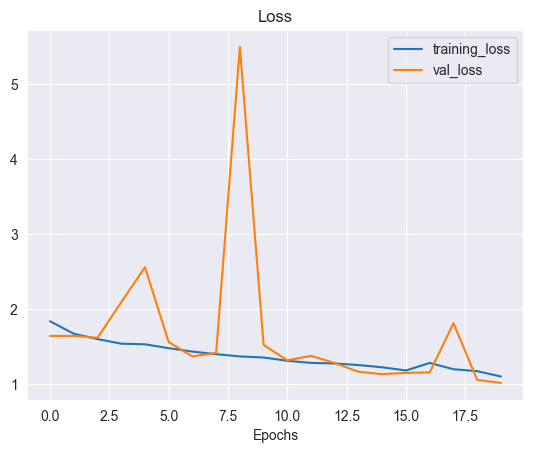

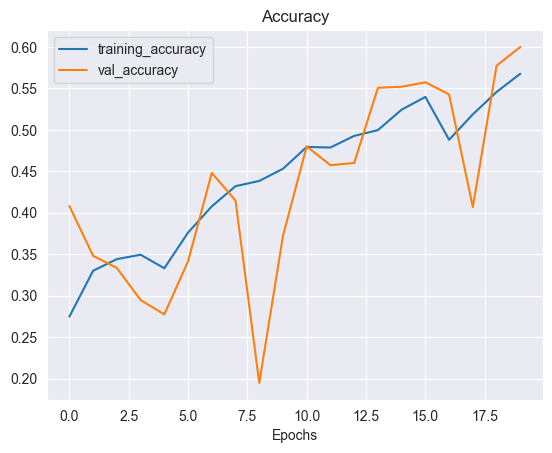

In [15]:
 # plot loss curves from history
plot_loss_curves(conv2_history)

In [16]:
loss, accuracy = conv2_model.evaluate(test_ds)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {accuracy}")

45/45 [==============================] - 5s 102ms/step - loss: 1.0348 - accuracy: 0.5848
Model loss on the test set: 1.034757137298584
Model accuracy on the test set: 0.5848000049591064


In summary, we have that result:
**model** -- Convolution Neural Network (CNN)
**result** --
accuracy = 0.58;
loss = 1.03;

## Exercise 3

#### Downloading Dataset
Our dataset is Emotion Detection from Text (from [kaggle](https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text?resource=download))

### Preprocessing Dataset

In [2]:
# Load dataset
tweet_emotions = pd.read_csv("datasets\\emotion_detection_text\\tweet_emotions.csv")

In [3]:
# Drop NA values
tweet_emotions.dropna(inplace=True)
tweet_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [4]:
# View dataset
print(tweet_emotions.head())

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...


In [5]:
# View dataset columns
tweet_emotions.keys()

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [6]:
# Drop unnecessary columns
tweet_emotions.drop(["tweet_id"], axis=1, inplace=True)

In [7]:
# View columns again
tweet_emotions.columns

Index(['sentiment', 'content'], dtype='object')

In [11]:
# View number of classes
set(tweet_emotions["sentiment"])

{'anger',
 'boredom',
 'empty',
 'enthusiasm',
 'fun',
 'happiness',
 'hate',
 'love',
 'neutral',
 'relief',
 'sadness',
 'surprise',
 'worry'}

In [12]:
# Leave only 3 classes
list_of_class = ["happiness", "sadness", "love"]
tweet_emotions = tweet_emotions.loc[tweet_emotions["sentiment"].isin(list_of_class)]

In [13]:
# View dataset classes again
set(tweet_emotions["sentiment"])

{'happiness', 'love', 'sadness'}

In [14]:
num_classes = len(list_of_class)
print(num_classes)

3


In [15]:
# View info about dataset
tweet_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14216 entries, 1 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14216 non-null  object
 1   content    14216 non-null  object
dtypes: object(2)
memory usage: 333.2+ KB


In [16]:
# View new dataset
print(tweet_emotions.head())

  sentiment                                            content
1   sadness  Layin n bed with a headache  ughhhh...waitin o...
2   sadness                Funeral ceremony...gloomy friday...
6   sadness  I should be sleep, but im not! thinking about ...
8   sadness            @charviray Charlene my love. I miss you
9   sadness         @kelcouch I'm sorry  at least it's Friday?


In [18]:
def clean_text(text_series):
    """
    Help function for cleaning dataset;
    :param text_series: pandas Series with string text data;
    :return: pandas Series with some changes in string cell.
    """
    # Set stopwords
    stop_words = stopwords.words("english")
    # Make cleaning
    text_series = text_series.str.lower()
    text_series = text_series.str.replace(r"@\S+", "")
    text_series = text_series.str.replace(r"https*\S+", "")
    text_series = text_series.str.replace(r"#\S+", "")
    text_series = text_series.str.replace(r"\d", "")
    text_series = text_series.str.replace(r"[%s]" % re.escape(string.punctuation), "")  # remove punctuations
    text_series = text_series.str.replace(r"\n", "")
    text_series = text_series.str.replace(r"\s{2,}", " ")
    # Remove Stop Words
    pat = r"\b(?:{})\b".format("|".join(stop_words))
    text_series = text_series.str.replace(pat, "")
    text_series = text_series.str.replace(r"\s+", " ")

    return text_series

In [19]:
# Cleaning Dataset
clean_tweet_emotions = tweet_emotions.copy()
clean_tweet_emotions["content"] = clean_text(clean_tweet_emotions["content"])

C:\Users\Who\AppData\Local\Temp\ipykernel_11844\1495260089.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  text_series = text_series.str.replace(r"@\S+", "")
C:\Users\Who\AppData\Local\Temp\ipykernel_11844\1495260089.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  text_series = text_series.str.replace(r"https*\S+", "")
C:\Users\Who\AppData\Local\Temp\ipykernel_11844\1495260089.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  text_series = text_series.str.replace(r"#\S+", "")
C:\Users\Who\AppData\Local\Temp\ipykernel_11844\1495260089.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  text_series = text_series.str.replace(r"\d", "")
C:\Users\Who\AppData\Local\Temp\ipykernel_11844\1495260089.py:15: FutureWarning: The default value of regex will change from True to False in a f

In [20]:
# View clean dataset
print(clean_tweet_emotions.head())

  sentiment                                            content
1   sadness             layin n bed headache ughhhhwaitin call
2   sadness                      funeral ceremonygloomy friday
6   sadness   sleep im thinking old friend want hes married...
8   sadness                                charlene love miss 
9   sadness                              im sorry least friday


In [21]:
def classification_confusion_evaluation(y_true, y_pred, classes=None):
    """
    Help function for viewing classification report of predictions and visualise confusion matrix;
    :param y_true: Array of truth labels (must be same shape as y_pred);
    :param y_pred: Array of predicted labels (must be same shape as y_true);
    :param classes: Array of class labels (as string).
    """
    model_accuracy = accuracy_score(y_true, y_pred)

    print("==>Classification Report<==")
    print(classification_report(y_true, y_pred))
    print("==========================")
    print("==>Model accuracy: {:.2f}".format(model_accuracy))

In [22]:
# View new dataframe
print(clean_tweet_emotions.head())

  sentiment                                            content
1   sadness             layin n bed headache ughhhhwaitin call
2   sadness                      funeral ceremonygloomy friday
6   sadness   sleep im thinking old friend want hes married...
8   sadness                                charlene love miss 
9   sadness                              im sorry least friday


In [23]:
# Replace string classes with integer classes
classes_dict = {"happiness": 0, "sadness": 1, "love": 2}
clean_tweet_emotions["sentiment"] = clean_tweet_emotions["sentiment"].apply(lambda x: classes_dict[x])

In [24]:
# Split dataset to x & y variables
x = clean_tweet_emotions["content"].to_numpy()
y = clean_tweet_emotions["sentiment"].to_numpy()

In [66]:
# Preprocess dataset as TF dataset
# tweet_ds = tf.data.Dataset.from_tensor_slices((x, y))
# next(iter(tweet_ds))
# Define hyperparameters
random_seed = 17
# Split dataset to train & test sets
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=random_seed)

In [67]:
# One-Hot encoding our labels
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [68]:
# Define Vectorizer
max_vocab_length = 4000
max_seq_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_seq_length)

In [69]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [70]:
# View shape of labels
y_train.shape

(12794, 3)

In [71]:
y_test.shape

(1422, 3)

In [72]:
# Check train labels
print(y_train)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [73]:
# Check test labels
print(y_test)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


### Build model

In [74]:
# Create an Embedding layer for our model
embedding_layer = Embedding(input_dim=max_vocab_length,
                            output_dim=100,
                            embeddings_initializer="uniform",
                            input_length=max_seq_length,
                            name="rnn_embedding")

In [81]:
# Build our model with our layers
inputs = Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = SpatialDropout1D(0.2)(x)
x = LSTM(75, dropout=0.3, recurrent_dropout=0.3)(x)
x = BatchNormalization()(x)
x = Dense(16, activation="relu")(x)
x = BatchNormalization()(x)
# x = Dropout(0.75)(x)
outputs = Dense(num_classes, activation="softmax")(x)

In [82]:
# Define model object
birnn_model = Model(inputs, outputs, name="rnn_model_LSTM")

In [83]:
# Compile the model
model_compile(birnn_model, CategoricalCrossentropy(), learn_rate=0.0003)

In [84]:
# View model summary
birnn_model.summary()

Model: "rnn_model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 rnn_embedding (Embedding)   (None, 15, 100)           400000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 15, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 75)                52800     
                                                                 
 batch_normalization (BatchN  (None, 75)            

### Fit model

In [85]:
# Fit model with train and test data
birnn_model_history = birnn_model.fit(X_train,
                                     y_train,
                                     epochs=5,
                                     validation_data=(X_test, y_test))

Epoch 1/5
400/400 [==============================] - 52s 118ms/step - loss: 0.7999 - accuracy: 0.6370 - val_loss: 0.9003 - val_accuracy: 0.5830
Epoch 2/5
400/400 [==============================] - 46s 114ms/step - loss: 0.6494 - accuracy: 0.7278 - val_loss: 0.9000 - val_accuracy: 0.6245
Epoch 3/5
400/400 [==============================] - 46s 116ms/step - loss: 0.6174 - accuracy: 0.7433 - val_loss: 0.8950 - val_accuracy: 0.6146
Epoch 4/5
400/400 [==============================] - 46s 115ms/step - loss: 0.6044 - accuracy: 0.7463 - val_loss: 0.9328 - val_accuracy: 0.5893
Epoch 5/5
400/400 [==============================] - 48s 119ms/step - loss: 0.5724 - accuracy: 0.7632 - val_loss: 0.9590 - val_accuracy: 0.6090


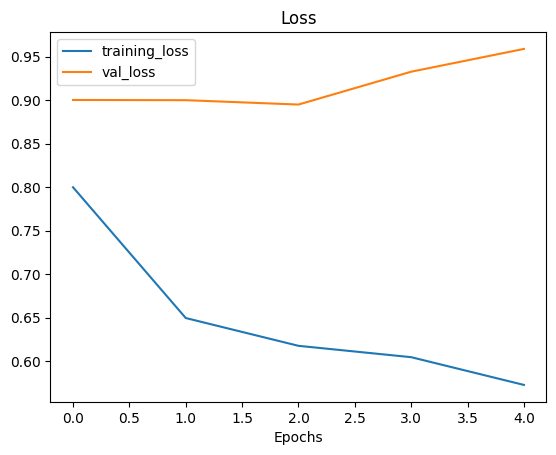

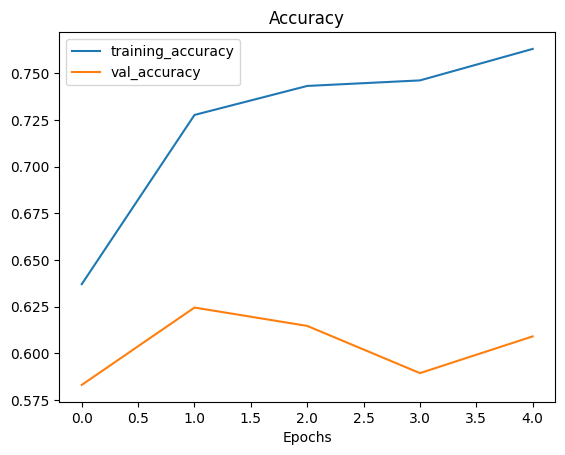

In [86]:
plot_loss_curves(birnn_model_history)

### Evaluate model

In [87]:
# Make predictions on the test dataset
rnn_model_pred_probs = birnn_model.predict(X_test)

45/45 [==============================] - 1s 16ms/step


In [88]:
# Round out predictions and reduce to 1-dimensional array
rnn_model_preds = tf.squeeze(tf.round(rnn_model_pred_probs))

In [89]:
# View on model predictions
rnn_model_preds

<tf.Tensor: shape=(1422, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [90]:
# View classification report and confusion matrix
classification_confusion_evaluation(y_test, rnn_model_preds, list_of_class)

==>Classification Report<==
              precision    recall  f1-score   support

           0       0.58      0.56      0.57       517
           1       0.72      0.69      0.71       518
           2       0.54      0.39      0.45       387

   micro avg       0.63      0.56      0.59      1422
   macro avg       0.61      0.55      0.58      1422
weighted avg       0.62      0.56      0.59      1422
 samples avg       0.56      0.56      0.56      1422

==>Confusion Matrix<==


D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: multilabel-indicator is not supported